# **Classificador Bayesiano**

In [23]:
import cv2
import os
from typing import Union

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

LABELS = { 'urban'    : 'Área Urbana',
           'tree'     : 'Vegetação Alta',
           'lowveget' : 'Vegetação Baixa', }

c_red   = np.array( [[255], [0], [0]] )
c_green = np.array( [[0], [255], [0]] ) 
c_blue  = np.array( [[0], [0], [255]] )

CLASS_COLORS = [ c_blue, c_green, c_red, ]

## Visualizando amostras de treinamento e validação

In [2]:
# ---------------------
# loader para amostras
def load_samples( stype: Union["train","val"], base_path: str, labels: list ):
  """Carrega imagens com seus respectivos rótulos."""
  
  # carregando imagems como np array
  samples = np.empty((0,2), dtype=object)
  for y, label in enumerate(labels):
    spath = os.path.join(base_path, stype, label)
    for img in os.listdir(spath):
      if img.endswith('.jpg'):
        x = cv2.imread(os.path.join(spath, img))[...,::-1] # fixando em RGB ao inves de BGR
        samples = np.append(samples, np.array([ [x,y] ], dtype=object), axis=0)
    
  # randomiza amostras mantendo a relação com a label
  np.random.shuffle(samples)
  return samples

# ---------------------
labels = list(LABELS.keys())
train_samples = load_samples('train', base_path='samples/', labels=labels)
val_samples = load_samples('val', base_path='samples/', labels=labels)

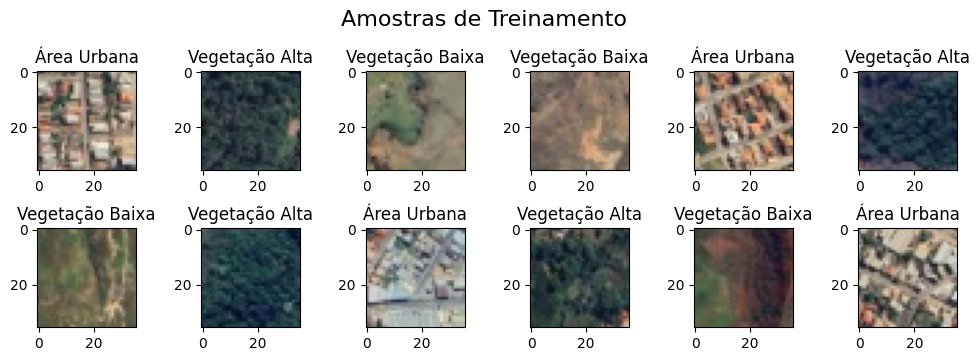

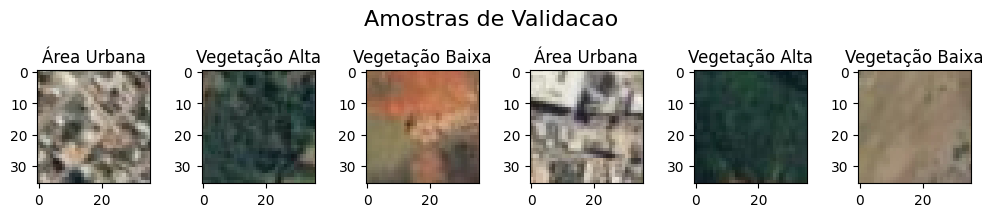

In [24]:
# ---------------------
# plot das amostras
def plot_samples(samples,labels,title=''):
  rows, cols = 3, 6
  plt.figure(figsize=(10,5))
  plt.suptitle(title, fontsize=16)
  for i, img in enumerate(samples[:,0]):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(labels[samples[:,1][i]])
  plt.tight_layout()
  plt.show()

# ---------------------
plot_samples(samples=train_samples, labels=list(LABELS.values()), title="Amostras de Treinamento")
plot_samples(samples=val_samples, labels=list(LABELS.values()), title="Amostras de Validação")


In [4]:
# ---------------------
def split_samples_on_yx(samples):
  
  flatten_imgs = np.array([ img.reshape(-1,3) for img in samples[:,0] ]).astype(np.float64)
  y_labels_ref = samples[:,1].astype(np.int64)

  xx = np.empty((0, 3, 1), dtype=np.float64)
  yy = np.empty((0, 1), dtype=np.int32)

  for i, img in enumerate(flatten_imgs):
    for r,g,b in img:
      # fazer o vetor coluna
      x = np.array([ [r],[g],[b] ], dtype=np.float64)
      xx = np.append( xx, [x], axis=0 )
      yy = np.append( yy, y_labels_ref[i] )  

  return xx, yy

# ---------------------
x_train, y_train = split_samples_on_yx(train_samples)
x_val, y_val = split_samples_on_yx(val_samples)

print(f"Train:  X {x_train.shape} Y {y_train.shape}")
print(f"Val :  X {x_val.shape} Y {y_val.shape}")


Train:  X (15552, 3, 1) Y (15552,)
Val :  X (7776, 3, 1) Y (7776,)


## Definindo o Classificador Bayesiano

O classificador contém os métodos para o ajuste dos seguintes parâmetros ( fit ):
- Para cada classe:
  - Pwj: Probabilidade a priori
  - Mj : vetor média
  - Cj : matriz coviariancia , determiante e inversa

Função discriminante:

$dj(x) = p(x/\omega_j) P(\omega_J)$

In [5]:
# ---------------------
# Definido o classificador em uma classe
class ClassifierBayes:
  """Define o classificador Bayesiano.
    Implementa os métodos:
     - fit()      : Faz o ajuste dos seguintes parâmetros
                        Pw    : probabilidade a priori para cada classe;
                        M     : vetor de médias das features para cada classe;
                        Cv    : matriz de covariâncias de cada classe;
                        C_det : determinante da matriz de covariâncias de cada classe;
                        C_inv : inversa da matriz de covariâncias de cada classe;

     - dx()       : Função discriminante;    
     - predict()  : Faz a predição de amostras por meio da função discriminante dj(x) para cada classe;     
  """
  
  def __init__(self, x_train, y_train, labels):
    self.x_train, self.y_train, self.labels = x_train, y_train, labels

    self.Pw,\
    self.M,\
    self.Cv,\
    self.C_det,\
    self.C_inv = self.fit( x_train, y_train, labels )
  
  def fit(self, x_train, y_train, labels):
    # P(wj) : Probabilidade a priori de cada classe;
    Pw = [ 1/len(labels) for j in range(len(labels)) ]
    
    # Mj : vetor de médias das features para cada classe;
    M = [ None for j in labels ]
    for j, _ in enumerate(labels):
      x = x_train[ j == y_train ]
      M[j] = np.array(np.mean(x, axis=0), dtype=np.float64)

    # Cv : matriz de covariâncias de cada classe;
    Cv = [ None for j in labels ]
    for j, _ in enumerate(labels):
      xj = x_train[ j == y_train ]
      cv_mtx = np.zeros((3,3), dtype=np.float64)
      for xji in xj:
        xxt, mmt = np.dot(xji, xji.T), np.dot(M[j], M[j].T)
        cv_mtx += xxt - mmt
      Nj = xj.shape[0]
      Cv[j] = 1/Nj * cv_mtx

    # determinante e inversa da matriz de coviariâncias;
    Cv_det = [ np.linalg.det(Cv[j])  for j in range(len(labels)) ]
    Cv_inv = [ np.linalg.pinv(Cv[j]) for j in range(len(labels)) ]

    print('>>> Fit:')
    print('\tComputed: Pw, M, Cv, C_det, C_inv')
    return Pw, M, Cv, Cv_det, Cv_inv

  def dx(self, x, j):
    # função discriminante
    Pwj, mj, Cj_det, Cj_inv = self.Pw[j], self.M[j], self.C_det[j], self.C_inv[j]
  
    dx = np.log(Pwj) - 1/2 * np.log(Cj_det) - 1/2 * np.dot( np.dot( (x - mj).T , Cj_inv ), ( x - mj ) )

    return dx[0][0]
  
  def predict(self, x):
    # faz a predição de uma amostra
    # retornando np.argmax(dj(x))
    dx = [ float('-inf') for j in self.labels ]
    for j, label in enumerate(self.labels):
      dx[j] = self.dx(x,j)

    return np.argmax(dx)

In [36]:
# -------------------------------
# fazer a sobreposição da imagem original com a classificada
def plot_result_img(input_img, result_img, title='', figsize=(16,12)):
  # --------------------------------
  # Plot resultados map00
  # Gerando a saída com overlay da imagem de entrada com a overlay de saida
  alpha = 0.65
  overlay00 = cv2.addWeighted(input_img.astype(np.int64), alpha, result_img, 1.0 - alpha, 0.0)
    
  # plot original / saida
  # plot resultados
  plt.figure(figsize=figsize)
  plt.suptitle(title, fontsize=16)
  
  plt.subplot(1, 2, 1)
  plt.imshow(input_img.astype(np.int64))
  plt.title("")
  
  plt.subplot(1, 2, 2)
  plt.imshow(overlay00)
  plt.title("")
  
  # obtém porcentagens de cada classe no mapa
  total = len(result_img.reshape(-1,3))
  # _, rgb = np.unique(result_img.reshape(-1,3), axis=0, return_counts=True)
  cont_rgb = [  np.count_nonzero(np.all(result_img.reshape(-1,3) == color.T, axis=1 )) for j, color in enumerate(CLASS_COLORS) ]  
  pb, pg, pr = [ round((c / total) * 100, 2) for c in cont_rgb ]
  
  # Legenda
  legend_colors = ['blue', 'green', 'red' ]
  legend_labels = [ f'Área Urbana ({pb})%', f'Árvores ({pg}%)', f'Vegetação Baixa ({pr}%)']
  legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
  # plt.legend(handles=legend_patches, loc='upper right')
  plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.05, 1.0))
  
  plt.show()
# -------------------------------
# método para realizar a classificação dos mapas
# com o modelo

def classify_map(model, input_img):
  # ------------------
  # Conveterndo o shape padrão para o classificador
  # Cada pixel como uma amostra,
  # Cada amostra como um vetor coluna [ [r] [g] [b] ]
  x_pred =  np.empty((0, 3, 1), dtype=np.float64)
  for r,g,b in input_img.reshape(-1,3):
    x_pred = np.append( x_pred, [np.array([ [r], [g], [b] ])], axis=0  )

  # ------------------------
  # definindo conjunto de cores para cada classe
  # tree, urban, lowveget
  class_colors = CLASS_COLORS

  result = np.empty(x_pred.shape, dtype=np.int64)

  # Faz a classificação da imagem e atribui a cor da classe
  # ao pixel na imagem de saída
  for i, x in enumerate(x_pred):
    y = model.predict(x)
    result[i] = class_colors[y]
  
  return result.reshape(input_img.shape)


## Formatando entradas:
  - (x,y) -> ( vetor coluna de pixels, rótulo para cada pixel )

In [7]:
# ---------------------
def split_samples_on_yx(samples):
  flatten_imgs = np.array([ img.reshape(-1,3) for img in samples[:,0] ]).astype(np.float64)
  y_labels_ref = samples[:,1].astype(np.int64)

  xx = np.empty((0, 3, 1), dtype=np.float64)
  yy = np.empty((0, 1), dtype=np.int32)

  for i, img in enumerate(flatten_imgs):
    for r,g,b in img:
      # fazer o vetor coluna
      x = np.array([ [r],[g],[b] ], dtype=np.float64)
      xx = np.append( xx, [x], axis=0 )
      yy = np.append( yy, y_labels_ref[i] )
  
  return xx, yy

# ---------------------
x_train, y_train = split_samples_on_yx(train_samples)
print(f"Train:  X {x_train.shape} Y {y_train.shape}")

Train:  X (15552, 3, 1) Y (15552,)


## Inicializando o Classificador

Os parâmetros são estimados/ajustados durante a inicialização do modelo

In [8]:
model = ClassifierBayes(x_train,y_train,labels)
print('Parametros ajustados:')
print(f"  PW: {model.Pw}")
print(f"  M: {model.M}")
print(f"  C_det: {model.C_det}")
print(f"  C_inv: {model.C_inv}")

>>> Fit:
	Computed: Pw, M, Cv, C_det, C_inv
Parametros ajustados:
  PW: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
  M: [array([[147.15239198],
       [135.92804784],
       [123.77970679]]), array([[43.21759259],
       [59.63387346],
       [66.5003858 ]]), array([[111.2339892 ],
       [102.27430556],
       [ 85.6257716 ]])]
  C_det: [24481932.010844223, 1829024.6654020466, 7520340.702201048]
  C_inv: [array([[ 0.00750302, -0.01446588,  0.00741959],
       [-0.01446588,  0.0372386 , -0.02354121],
       [ 0.00741959, -0.02354121,  0.01704488]]), array([[ 0.01132474, -0.01184121, -0.00010241],
       [-0.01184121,  0.02463749, -0.01252726],
       [-0.00010241, -0.01252726,  0.01696408]]), array([[ 0.00765538, -0.00345446, -0.0059547 ],
       [-0.00345446,  0.01065095, -0.00848644],
       [-0.0059547 , -0.00848644,  0.02027353]])]


## Avaliando a acurácia com amostras de validação

Com o modelo inicializado, podemos verificar o desempenho por meio da matriz de confusão e acurácia com amostras de validação rotuladas.

In [9]:
# ---------------------
# Formatando amostras de validação
x_val, y_val = split_samples_on_yx(val_samples)
print(f"Val :  X {x_val.shape} Y {y_val.shape}")

Val :  X (7776, 3, 1) Y (7776,)


In [10]:
# ---------------------
# Faz a predição das amostras de validação

# armazena as predições
y_true = y_val
y_pred = np.empty((0,1), dtype=np.int64)

for x in x_val:
  y = model.predict(x)
  y_pred = np.append(y_pred, y)

# acurácia geral
correct_predictions = np.sum( y_pred == y_true )
total_predictions   = len(y_true)
total_acc = correct_predictions / total_predictions

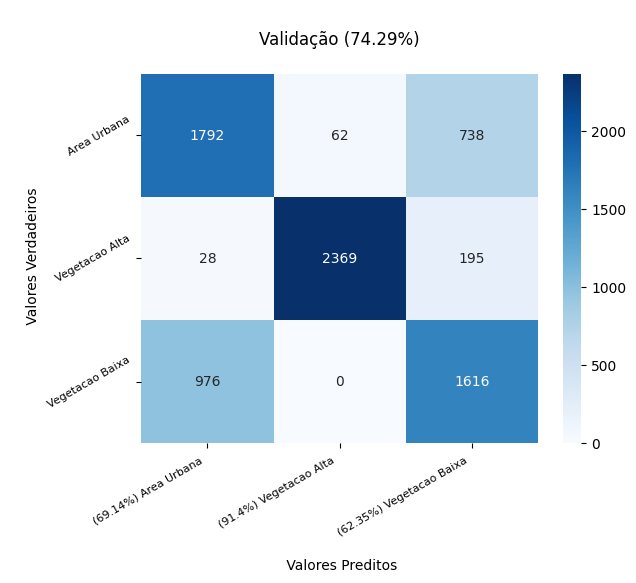

In [11]:
# ---------------------
# Vizualizanado as métricas
n_labels = len(LABELS.keys())

# matriz de confusão
cf_matrix = np.zeros(( n_labels, n_labels ), dtype=np.int64)
for i, _ in enumerate(y_true):
  cf_matrix[ y_true[i], y_pred[i] ] += 1
  
# obtendo acc de cada classe a partir da matriz de confusao
cf_acc = { i : round( (cf_matrix[ i,i ] / cf_matrix [ i, :].sum() )*100,2) for i in range(n_labels) }

# plotando métricas
ax = plt.gca()
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues', ax=ax)
ax.set_title(f"\nValidação ({round(total_acc * 100, 2)}%)\n")
ax.set_xlabel('\n Valores Preditos')
ax.set_ylabel('\n Valores Verdadeiros')

# tick para as labels
lb_names = list(LABELS.values())
ax.xaxis.set_ticklabels( [ f"({cf_acc[i]}%) {LABELS[j]} " for i,j in enumerate(labels) ], rotation=30, horizontalalignment='right', fontsize=8)
ax.yaxis.set_ticklabels( [ f"{LABELS[j]}" for i,j in enumerate(labels) ], rotation=30, horizontalalignment='right', fontsize=8)
print('')


### Vizualizando como o modelo classificou cada amostra de validação

A qualidade das amostras pode ser avaliada como a classificação se comporta com os dados de validação, onde as imagens contém elementos referentes apenas a uma classe.

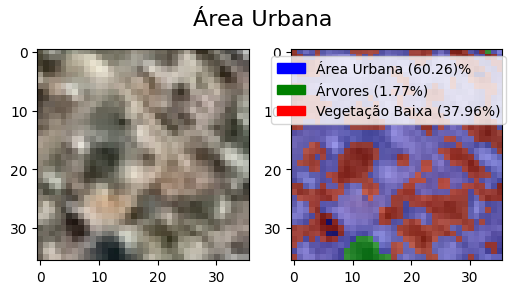

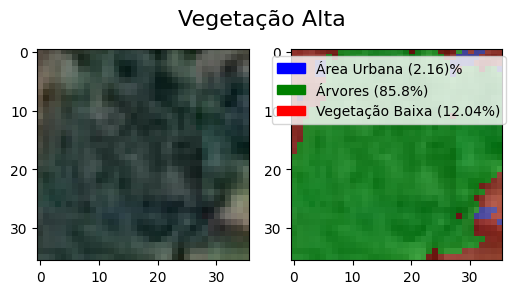

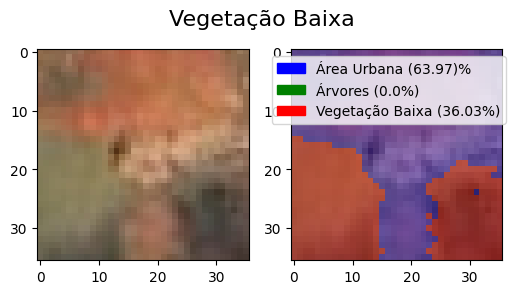

In [37]:
# input_val, input_val_class = val_samples[0]
for img_val, label_val in val_samples[:3]:
  result_img = classify_map(model, img_val)
  plot_result_img(img_val, result_img, figsize=(6, 3), title=list(LABELS.values())[label_val])


## Classificando mapas


In [13]:
# --------------------------------
# Mapa 00
img00 = 'inputs/map00.jpg'
input00 = cv2.imread( img00 )[...,::-1] # fixando em RGB ao inves de BGR
# classificando o mapa
result00 = classify_map(model, input00)

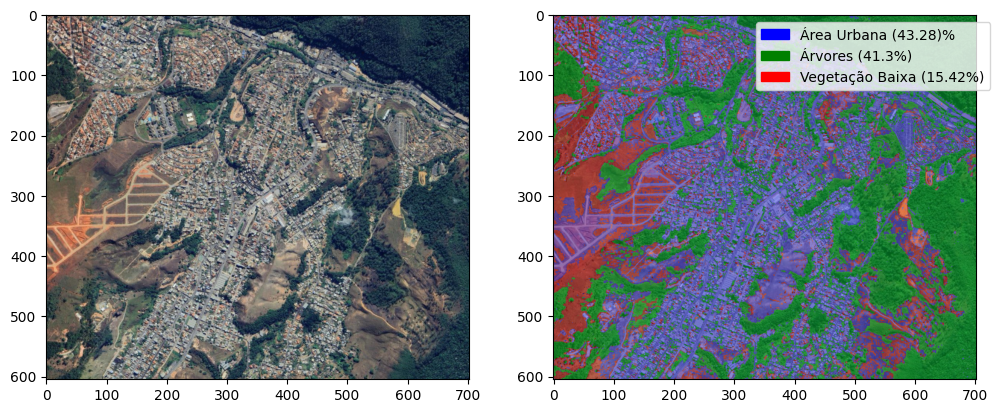

In [42]:
plot_result_img(input00, result00, figsize=((12,5)))

In [20]:
# --------------------------------
# Mapa 01
img01 = 'inputs/map01.jpg'
input01 = cv2.imread( img01 )[...,::-1] # fixando em RGB ao inves de BGR
# classificando o mapa
result01 = classify_map(model, input01)

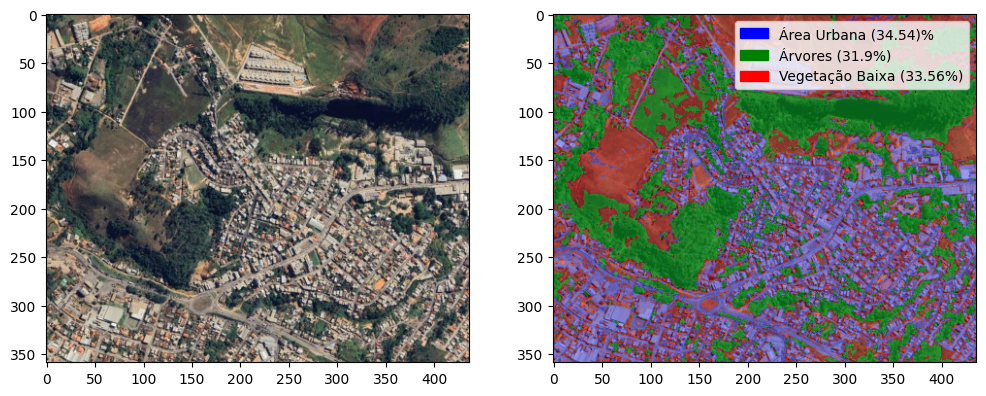

In [21]:
plot_result_img(input01, result01, figsize=((12,5)))

In [15]:
# --------------------------------
# Mapa 02
img02 = 'inputs/map02.jpg'
input02 = cv2.imread( img02 )[...,::-1] # fixando em RGB ao inves de BGR
# classificando o mapa
result02 = classify_map(model, input02)

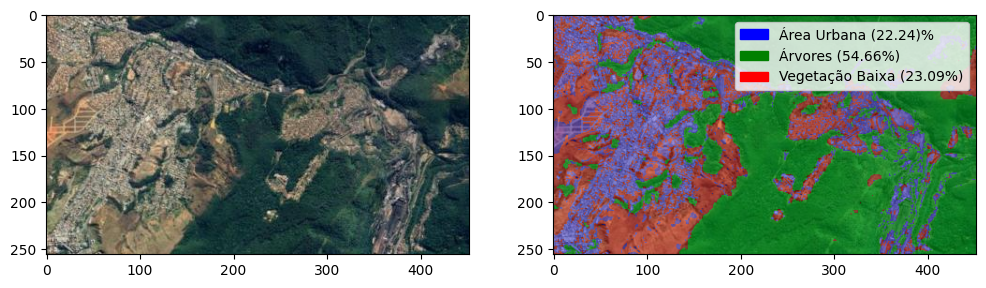

In [16]:
plot_result_img(input02, result02, figsize=((12,5)))

In [17]:
# --------------------------------
# Mapa 03
img03 = 'inputs/map03.jpg'
input03 = cv2.imread( img03 )[...,::-1] # fixando em RGB ao inves de BGR
# classificando o mapa
result03 = classify_map(model, input03)

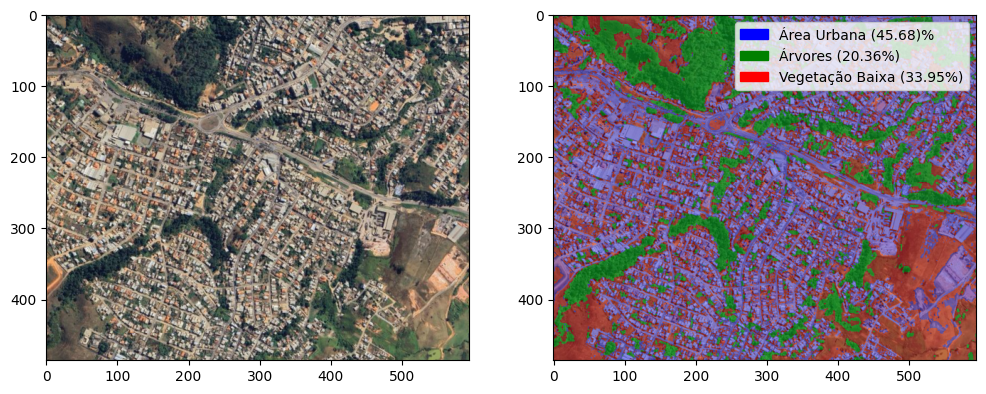

In [22]:
plot_result_img(input03, result03, figsize=((12,5)))